In [ ]:
# Run in Colab to install local packages
!pip install datasets gensim sentence_transformers tqdm

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

import datasets
import os

In [2]:
sciq = datasets.load_dataset("allenai/sciq")

In [3]:
train = sciq["train"]

In [4]:
print(train[0])

{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [15]:
inference = pd.read_csv(os.path.join("datasets", "inference_quantitative_analysis.tsv"), sep="\t", header=0)
inference

,id,case,support,answer,question,distractor1,distractor2,distractor3
0,0,ground_truth,Oxidants and Reductants Compounds that are cap...,oxidants,Compounds that are capable of accepting electr...,antioxidants,Oxygen,residues
1,0,answer_given,Oxidants and Reductants Compounds that are cap...,oxidants,What are compounds that are capable of accepti...,acids,enzymes,reductants
2,1,ground_truth,But transgenic animals just have one novel gen...,clone,What term in biotechnology means a genetically...,adult,male,phenotype
3,1,answer_given,But transgenic animals just have one novel gen...,clone,What is a genetically exact copy of an organis...,replica,duplicate,replica
4,2,ground_truth,Figure 29.7 Vertebrata are characterized by th...,backbone,Vertebrata are characterized by the presence o...,Bones,Muscles,Thumbs
...,...,...,...,...,...,...,...,...
1756,996,answer_given,"Short-period comets come from the Kuiper belt,...",kuiper belt,Where do short-period comets come from?,Oort cloud,Kuiper-Oort cloud,Kuiper-Kuiper cloud
1757,998,ground_truth,Atoms with unstable nuclei are radioactive. To...,radioactive,What are atoms with unstable nuclei are consid...,ions,unstable,destructive
1758,998,answer_given,Atoms with unstable nuclei are radioactive. To...,radioactive,Atoms with unstable nuclei are what?,toxic,radioactive,unstable
1759,999,ground_truth,"On land, sulfur is deposited in four major way...",sulfur dioxide (so2),In what form is atmospheric sulfur found?,formaldehyde,sulfuric acid,sulfur monoxide


In [50]:
groundTruth = inference[inference["case"] == "ground_truth"]
answerGiven = inference[inference["case"] == "answer_given"]

groundTruth = datasets.Dataset.from_pandas(groundTruth, preserve_index = False)
groundTruth = groundTruth.rename_column("answer", "correct_answer")
answerGiven = datasets.Dataset.from_pandas(answerGiven, preserve_index = False)
answerGiven = answerGiven.rename_column("answer", "correct_answer")

answerGiven[3]

{'id': 3,
 'case': 'answer_given',
 'support': 'As you know, the surface of Earth is not flat. Some places are high, and some places are low. For example, mountain ranges like the Sierra Nevada in California or the Andes in South America are high above the surrounding areas. An accurate location must take into account the third dimension. Elevation is the height above or below sea level. Sea level refers to the height of the ocean’s surface. This is the midpoint between high and low tide. Sea level can vary from place to place, but scientists base their elevation measurements on the average, or mean, sea level to make sure they have a standard reference point.',
 'correct_answer': 'elevation',
 'question': 'What is the term for the height above or below sea level?',
 'distractor1': 'latitude',
 'distractor2': 'longitude',
 'distractor3': 'altitude'}

## Length of answers and distractors

In [32]:
def get_max_length(sample):
    return {
        "max_length": max(
            [len(sample[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]
        )
    }


train = train.map(get_max_length, remove_columns=["question", "support"])

Map:   0%|          | 0/11679 [00:00<?, ? examples/s]

In [45]:
train_df = train
train_df.set_format("pandas")
train_df = train_df[:]
# train_df["len_correct_answer"] = train_df["correct_answer"].apply(lambda x: len(x.split(" ")))
train_df["max_length"] = train_df.apply(
    lambda x: max([len(x[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]),
    axis=1)

frequencies = (
#         train_df["len_correct_answer"]
    train_df["max_length"]
    .value_counts().to_frame().reset_index()
    .rename(columns={"index": "number of words", "max_length": "frequency"})
)
train.set_format()
frequencies

,number of words,frequency
0,1,6204
1,2,4018
2,3,1142
3,4,196
4,5,64
5,6,26
6,7,14
7,8,5
8,9,3
9,10,3


## Word embeddings

In [6]:
# fasttext = gensim.downloader.load("fasttext-wiki-news-subwords-300")
# fasttext = gensim.models.KeyedVectors.load("ft") #, mmap='r'

In [7]:
print(fasttext.similarity("viruses", "protozoa"))
print(fasttext.similarity("protozoa", "viruses"))

0.52428013
0.52428013


In [9]:
small = train.select([i for i in range(10)])
print(small)
print(small[0])

Dataset({
    features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
    num_rows: 10
})
{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [63]:
ansToDist = []
distToDist = []
for i, sample in enumerate(train):
    if sample["max_length"] > 1:
        continue
    try:
        sim = [
            fasttext.similarity(sample["correct_answer"], sample[distractor])
            for distractor in ["distractor1", "distractor2", "distractor3"]
        ]
        ansToDist.extend(sim)
        if max(sim) >= 1.0:
            print(i)
        sim = [
            fasttext.similarity(sample["distractor" + str(a)], sample["distractor" + str(b)])
            for a, b in [(1, 2), (1, 3), (2, 3)]
        ]
        distToDist.extend(sim)
    except KeyError:
        continue

1481
4997
5387
5558
11108
11116


In [54]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,17109.000000
mean,0.511500
std,0.141269
min,-0.056659
25%,0.420177
50%,0.496206
75%,0.589245
max,1.000000


In [53]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,17109.000000
mean,0.469450
std,0.139733
min,-0.020514
25%,0.377366
50%,0.456741
75%,0.544530
max,1.000000


In [57]:
npAnsToDist = np.array(ansToDist)

(array([  11.,   39.,  323., 1806., 4843., 5349., 2962., 1074.,  341.,
         361.]),
 array([-0.05665937,  0.04900656,  0.1546725 ,  0.26033843,  0.36600438,
         0.4716703 ,  0.57733625,  0.6830022 ,  0.7886681 ,  0.8943341 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

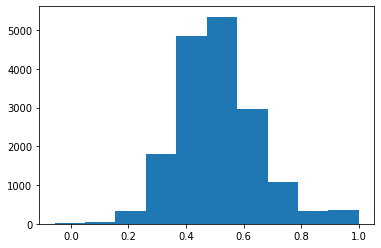

In [69]:
plt.hist(npAnsToDist, bins=10)

(array([  13.,  137.,  987., 3686., 5565., 3900., 1762.,  622.,  194.,
         243.]),
 array([-0.02051357,  0.08153778,  0.18358915,  0.2856405 ,  0.38769186,
         0.4897432 ,  0.59179455,  0.6938459 ,  0.7958973 ,  0.8979486 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

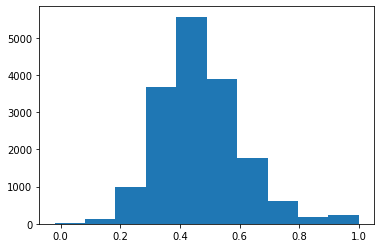

In [70]:
plt.hist(distToDist, bins=10)

## Sentence embeddings

In [46]:
model = SentenceTransformer(
    "all-mpnet-base-v2"
)  # See for other pretrained models: https://www.sbert.net/docs/pretrained_models.html

In [85]:
def getSentenceSimilarities(dataset, removePerfectSimilarities = False):
    ansToDist = []
    distToDist = []

    keys_to_encode = ["correct_answer", "distractor1", "distractor2", "distractor3"]
    for i, sample in enumerate(tqdm(dataset)):
        strings_to_encode = [sample[j] for j in keys_to_encode]
        embeddings = {key: value for key, value in zip(keys_to_encode, model.encode(strings_to_encode))}

        sim = util.cos_sim(
            embeddings["correct_answer"],
            np.array([embeddings[distractor] for distractor in ["distractor1", "distractor2", "distractor3"]]),
        )
        sim = sim.numpy()[0]
        ansToDist.extend(sim)

        sim = [
            util.cos_sim(embeddings["distractor" + str(a)], embeddings["distractor" + str(b)]).item()
            for a, b in [(1, 2), (1, 3), (2, 3)]
        ]
        distToDist.extend(sim)
    
    if removePerfectSimilarities:
        ansToDist = [x for x in ansToDist if x < 1.0]
        distToDist = [x for x in distToDist if x < 1.0]
    
    return ansToDist, distToDist

In [86]:
ansToDistGT, distToDistGT = getSentenceSimilarities(groundTruth, removePerfectSimilarities = True)
ansToDistAG, distToDistAG = getSentenceSimilarities(answerGiven, removePerfectSimilarities = True)

100%|██████████| 877/877 [00:19<00:00, 44.48it/s]


In [88]:
pd.DataFrame({"ansToDist Ground Truth":ansToDistGT}).describe()

,ansToDist Ground Truth
count,2652.000000
mean,0.453155
std,0.179769
min,0.032064
25%,0.320338
50%,0.439172
75%,0.571298
max,0.976144


In [89]:
pd.DataFrame({"distToDist Ground Truth:": distToDistGT}).describe()

,distToDist Ground Truth:
count,2647.000000
mean,0.405347
std,0.171571
min,-0.012216
25%,0.272554
50%,0.388052
75%,0.518227
max,0.976091


In [90]:
pd.DataFrame({"ansToDist Answer Given":ansToDistAG}).describe()

,ansToDist Answer Given
count,2543.000000
mean,0.523479
std,0.184558
min,0.038109
25%,0.387583
50%,0.510599
75%,0.646416
max,1.000000


In [91]:
pd.DataFrame({"distToDist Answer Given:": distToDistAG}).describe()

,distToDist Answer Given:
count,2436.000000
mean,0.528824
std,0.181984
min,0.019902
25%,0.395768
50%,0.511877
75%,0.649912
max,1.000000


(array([ 0.70782536,  3.81439233, 10.18482018, 17.65631104, 19.18993187,
        17.18442726, 14.86433315,  8.57255173,  5.58395576,  2.24144697]),
 array([0.03810859, 0.13429773, 0.23048687, 0.326676  , 0.42286512,
        0.5190543 , 0.6152434 , 0.7114325 , 0.80762166, 0.9038108 ,
        0.99999994], dtype=float32),
 <BarContainer object of 10 artists>)

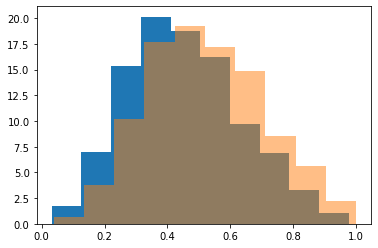

In [97]:
plt.hist(ansToDistGT, bins=10, weights=np.zeros_like(ansToDistGT) + 100. / len(ansToDistGT))
plt.hist(ansToDistAG, bins=10, weights=np.zeros_like(ansToDistAG) + 100. / len(ansToDistAG), alpha = 0.5)

(array([ 0.12315271,  2.50410509,  9.03119869, 16.37931034, 21.67487685,
        17.61083744, 15.96880131,  8.16912972,  5.82922824,  2.70935961]),
 array([0.01990199, 0.11791179, 0.21592158, 0.31393138, 0.41194117,
        0.50995097, 0.60796076, 0.70597056, 0.80398035, 0.90199015,
        0.99999994]),
 <BarContainer object of 10 artists>)

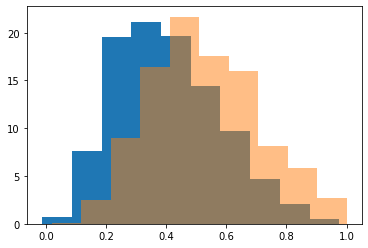

In [98]:
plt.hist(distToDistGT, bins=10, weights=np.zeros_like(distToDistGT) + 100. / len(distToDistGT))
plt.hist(distToDistAG, bins=10, weights=np.zeros_like(distToDistAG) + 100. / len(distToDistAG), alpha = 0.5)

## Old code

In [7]:
def get_similarities(sample):
    if len(sample["correct_answer"].split(" ")) > 1:
        return {
            "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }
    try:
        return {
            "correct_to_distractor": [
                fasttext.similarity(sample["correct_answer"], sample[distractor])
                for distractor in ["distractor1", "distractor2", "distractor3"]
            ],
            "distractor_to_distractor": [
                fasttext.similarity(sample["distractor" + str(a)], sample["distractor" + str(b)])
                for a, b in [(1, 2), (1, 3), (2, 3)]
            ],
        }
    except KeyError:
        return {
            "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }

### Finding bad samples

In [ ]:
np.argmax(npAnsToDist)
train[1481]